In [1]:
# This example shows quantum cloning in one dimension. 

# Reference:
# V. Buzek, S.L. Braunstein, M. Hillery, and D. Bruß, "Quantum copying: A network"

In [2]:
# import
import numpy as np
import scipy.linalg as lin
import itertools
from math import pi
import matplotlib.pyplot as plt

# %matplotlib inline

from qiskit import (
    QuantumCircuit,
    Aer,
    transpile,
)
from qiskit.visualization import (
    plot_histogram,
    plot_bloch_multivector
)
from qiskit.quantum_info import (
    partial_trace,
)
from qiskit.circuit.library.standard_gates import UGate

print("Imports Successful")


Imports Successful


In [3]:
def calc_theta(p):
    if p >= 0:
        return 2 * np.arccos(np.sqrt(p))
    else:
        return -2 * np.arccos(np.sqrt(-p))


def calc_attenuate_theta(p0, p1):
    return calc_theta(p1/p0)


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits)
                for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


def round_mat(mat, delta):
    mat_real = mat.real
    mat_imag = mat.imag
    mat_real = np.where(np.logical_and(-delta < mat_real,
                        mat_real < delta), 0.0, mat_real)
    mat_imag = np.where(np.logical_and(-delta < mat_imag,
                        mat_imag < delta), 0.0, mat_imag)
    return mat_real + mat_imag * 1.0j


def fidelity(rho, sigma):
    rho_round = round_mat(rho, 0.00001)
    sigma_round = round_mat(sigma, 0.00001)
    rho_1_2, _ = lin.sqrtm(np.array(rho_round), False)
    sq_fidelity_mat = np.matmul(
        np.matmul(rho_1_2, np.array(sigma_round)), rho_1_2)
    fidelity_mat, _ = lin.sqrtm(sq_fidelity_mat, False)
    return np.trace(fidelity_mat)


def fidelity_alt(rho, sigma):
    density_diff = rho - sigma
    fidelity_mat = np.matmul(density_diff, density_diff)
    return np.trace(fidelity_mat)


In [4]:
def setup_state(qsetup, qc, q0):
    if type(qsetup) == tuple:
        q0_setup = qsetup
        qc.u(q0_setup[0], q0_setup[1], q0_setup[2], q0)
    else:
        if qsetup == "|0>":
            pass
        elif qsetup == "|1>":
            qc.x(q1)
        else:
            raise Exception("Invalid qsetup {}".format(qsetup))


def setup_U(Usetup, qc, q0):
    if type(Usetup) == tuple:
        q0_setup = Usetup
        qc.u(q0_setup[0], q0_setup[1], q0_setup[2], q0)
    else:
        qc.x(q0)


def calc_qc_fidelity(qc_setup, sampleN):
    # calculate the fidelity of cloning
    def calc_density(sim_setup):
        sv_simulator = sim_setup[0]
        circuit = sim_setup[1]
        trace_reduced = sim_setup[2]
        trace_measure = sim_setup[3]
        statevector_sim = np.asarray(
            sv_simulator.run(circuit).result().data()['statevector'])
        if len(trace_measure) > 0:
            statedensity_measure = np.array(partial_trace(
                statevector_sim, trace_measure)).real
        return True, np.array(
            partial_trace(statevector_sim, trace_reduced))

    def calc_density_list(sim_setup, sampleN):
        count = 0.0
        count_success = 0.0
        density_list = []
        statedensity = None
        while True:
            if count >= sampleN:
                break
            if len(sim_setup[3]) > 0 or statedensity is None:
                flag, statedensity = calc_density(sim_setup)
            count += 1.0
            if not flag:
                continue
            count_success += 1.0
            density_list.append(statedensity)
        return density_list, count_success/count

    # make sim_setup_list
    sim_setup_list = []
    for qc, qc_qbits, qc_cbits in qc_setup:
        trace_reduced = list(set(list(range(qc.num_qubits))) - set(qc_qbits))
        trace_measure = list(set(list(range(qc.num_qubits))) - set(qc_cbits))
        sv_simulator = Aer.get_backend('statevector_simulator')
        sim_setup_list.append(
            (sv_simulator,
             transpile(qc, backend=sv_simulator),
             trace_reduced,
             trace_measure)
        )

    # calculate the average of fidelity
    density_list0, success_rate0 = calc_density_list(
        sim_setup_list[0], sampleN)
    density_list1, success_rate1 = calc_density_list(
        sim_setup_list[1], sampleN)
    avg_fidelity = 0.0
    for density0, density1 in zip(density_list0, density_list1):
        avg_fidelity += fidelity(density0, density1) / sampleN

    return avg_fidelity, success_rate0, success_rate1


def calc_qc_fidelity_list(qsetup_list, qc_build_setup, sampleN):
    fidelity_list = []
    for qsetup in qsetup_list:
        qc_setup = (
            (qc_build_setup[0][0](qsetup), *qc_build_setup[0][1:3]),
            (qc_build_setup[1][0](qsetup), *qc_build_setup[1][1:3]),
        )
        avg_fidelity, success_rate0, success_rate1 = calc_qc_fidelity(
            qc_setup, sampleN)
        fidelity_list.append(
            (qsetup, avg_fidelity, success_rate0, success_rate1))
    return fidelity_list


def calc_global_fidelity(qc_build_setup):
    sampleN = 100
    num0 = 5
    num1 = 8
    q0_theta_list = np.linspace(0, pi, num0, endpoint=True)
    q0_phi_list = np.linspace(-pi, pi, num1, endpoint=False)

    # make qsetup_list
    qsetup_list = []
    for q0_theta, q0_phi in itertools.product(q0_theta_list, q0_phi_list):
        if q0_theta == 0 and q0_phi != -pi:
            continue
        if q0_theta == pi and q0_phi != -pi:
            continue
        # q0 (= cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>)
        q0_setup = (q0_theta, q0_phi, 0)
        qsetup_list.append(q0_setup)

    # calculate the fidelity
    fidelity_result_list = calc_qc_fidelity_list(
        qsetup_list, qc_build_setup, sampleN)

    # arrange the result into a list.
    sum_success_rate = 0.0
    fidelity_list = np.empty([0])
    for fidelity_result in fidelity_result_list:
        fidelity_list = np.append(fidelity_list, [fidelity_result[1].real])
        sum_success_rate += fidelity_result[3]

    print(f'number of points = {len(fidelity_result_list)}')
    return fidelity_list, fidelity_result_list


def plot_fidelity(qc_build_setup, q0_in_setup):
    # q0 is set to cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>
    sampleN = 1
    theta3_list = np.linspace(-pi, pi, 32)
    sum_success_rate = 0

    # make qsetup_list
    qsetup_list = []
    for theta3 in theta3_list:
        q0_setup = (theta3, q0_in_setup[1], q0_in_setup[2])
        qsetup_list.append(q0_setup)

    # calculate the fidelity
    fidelity_list = calc_qc_fidelity_list(
        qsetup_list, qc_build_setup, sampleN)
    
    # plot the fidelity
    sum_success_rate = 0.0
    y_list = np.empty([0, 2])
    for fidelity_info in fidelity_list:
        y_list = np.append(y_list, [fidelity_info[1].real])
        sum_success_rate += fidelity_info[3]
    plt.plot(theta3_list, y_list)
    plt.title(f"Fidelity\n(initial state q0 = (theta, {q0_in_setup[1]:.2f}, {q0_in_setup[2]:.2f})")
    plt.ylim([0, 1])
    plt.ylabel("Fidelity")
    plt.xlabel("theta")



In [5]:
# quantum circuit
def example_no_clone(qsetup):
    # q0
    # q1 = q0
    qc = QuantumCircuit(2)
    setup_state(qsetup, qc, 0)
    setup_state(qsetup, qc, 1)
    return qc


def example_clone(qsetup):
    # q0: input (a|0> + b|1>), clone3 if a and b are real
    # q1: clone1
    # q2: clone2
    qc = QuantumCircuit(3)

    theta1 = pi/8 * 2
    theta2 = -np.arcsin(np.sqrt(1.0/2 - np.sqrt(2.0)/3)) * 2
    theta3 = pi/8 * 2
    
    setup_state(qsetup, qc, 0)

    qc.barrier()

    angle = 0
    qc.u(theta1, angle, angle, 1)
    qc.cx(1, 2)
    qc.u(theta2, angle, angle, 2)
    qc.cx(2, 1)
    qc.u(theta3, angle, angle, 1)

    qc.barrier()

    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(1, 0)
    qc.cx(2, 0)
    
    return qc

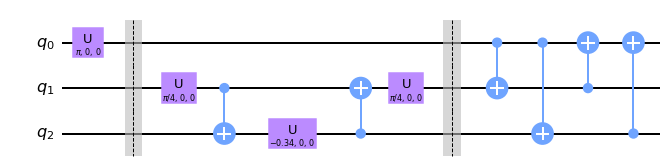

In [6]:
# cloning
qc = example_clone((pi, 0, 0))
qc.draw(output="mpl")


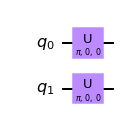

In [7]:
# no cloning
qc = example_no_clone((pi, 0, 0))
qc.draw(output="mpl")


In [8]:
q0_rand_setup = (float(pi*np.random.rand(1)), 0, 0) # (theta, phi, lambda)


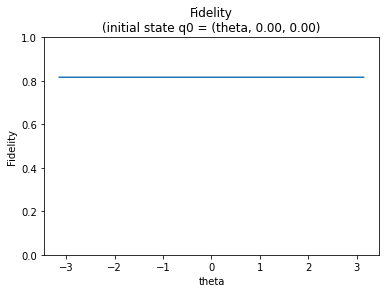

In [9]:
# example: q0 (= cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>)
# fidelity of q1 and q2

plot_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0, q1 = q0
        # q1 (clone of q0), q2 (clone of q0)
        (example_clone, [1, 2], []),
    ),
    q0_rand_setup,
)


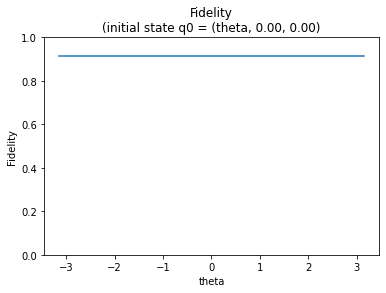

In [10]:
# example: q0 (= cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>)
# fidelity of q1

plot_fidelity(
    (
        (example_no_clone, [0], []),  # q0
        # q1 (clone of q0)
        (example_clone, [1], []),
    ),
    q0_rand_setup,
)


In [11]:
# example: q0 (= cos(theta0/2)|0> + exp(i*phi0)*sin(theta0/2)|1>)

fidelity_list0, fidelity_result_list0 = calc_global_fidelity(
    (
        (example_no_clone, [0, 1], []),  # q0, q1 = q0
        # q1 (clone of q0), q2 (clone of q0)
        (example_clone, [1, 2], []),
    )
)
print(f'fidelity = {np.min(fidelity_list0)}')

number of points = 26
fidelity = 0.8164965809277274
